In [1]:
# import warnings
# warnings.filterwarnings('ignore')
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="darkgrid")

SOURCE_DATA_PATH = 'source_data'
DERIVED_DATA_PATH = 'derived_data'

##Data Preparation

Below we're going to join the needs and wellness domains, as it's our intended feature space.

In [2]:
needs = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_needs.csv'), na_values=' ', index_col='ID')
wellness = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_wellness.csv'), na_values=' ', index_col='ID')

km_X = needs.join(wellness).dropna() 

In [3]:
print 'data retention post-drop: {:.2%} percent.'.format(float(len(km_X))/len(needs))
print '# records retention post-drop: {}'.format(len(km_X))

data retention post-drop: 69.73% percent.
# records retention post-drop: 211646


So that's not bad.  Let's keep going with our cluster analysis by building our model.

##Building Model

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

It'll make most sense for us to run the model over several k's to arrive at the optimal k for our data.  To evaluate cluster validity we're going to consider two metrics: the Silhouette Coefficient & our old friend Sum of Squared Errors.  We don't get SSE out of the box with sklearn so we'll write our own.  Let's do that first.

**Sum of Squared Errors Definition:**

$$
SSE = \displaystyle\sum_{i=1}^{K}\sum_{x \in C_i} d(x, c_i)^2
$$

Now implementation...

In [5]:
#SSE get_cluster_centers helper function
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        #get mean coordinates of each cluster
        CC_list.append(np.mean(X[labels ==k], axis=0))
    return CC_list

#main SSE function
#for each cluster subtract the mean from each data point to get the error
#then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X,labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)   

In [6]:
km_X = km_X.sample(n=10000, random_state=1)

In [11]:
k_range = range(2,10)

Here we'll run "k_range" models with k clusters.

In [21]:
#@Ceslee: Check to make sure SC/SSE incongruence isn't due to data dist.
#@Ceslee: Replace sampling with full dataset if you can.
#@Ceslee: Try silhouette coefficient visualization from scikitlearn if that helps.
#@Ceslee: Why is timeit not working?
#@Ceslee: write out SC formula too
time = %timeit

SSEs = []
Sil_coefs = []

for k in k_range:
    #instantiate KMeans object
    km = KMeans(n_clusters=k, random_state=1)
    #fit model to training data
    km.fit(km_X)
    labels = km.labels_
    #store SC & SSE scores for each k run
    Sil_coefs.append(metrics.silhouette_score(km_X, labels, metric='euclidean'))
    SSEs.append(get_SSE(km_X, labels))

print time

KeyboardInterrupt: 

Let's plot the SSE and SC to see where our optimum k lies.

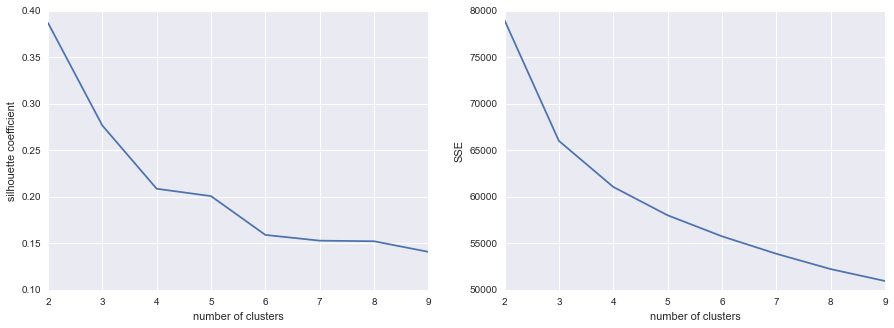

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
ax1.plot(k_range, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_range, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

On interpreting the Average Silhouette Coefficient from [sckit-learn.org](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html): 
> Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Interestingly, to maximize SC our plot indicates we should choose k=2 and to minimize SSE (and try to minimize # clusters to min. comp time and support human intuition) our plot indicates we should choose k=3.  I'm a fan of trying both to see how it affects possible interpretations later on.  But what we can do is visualize a PCA-reduced 2-dim plot of our clustering job to see if that will help us make a final call.

In [63]:
#helper function first
def show_kmeans_plot(fig_num, k, kmeans, reduced_data):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(reduced_data)
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() + 1, reduced_data[:, 0].max() - 1
    y_min, y_max = reduced_data[:, 1].min() + 1, reduced_data[:, 1].max() - 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(fig_num)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on PCA-reduced data where k = {}\n'
              'Centroids are marked with white cross'.format(k))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    return plt

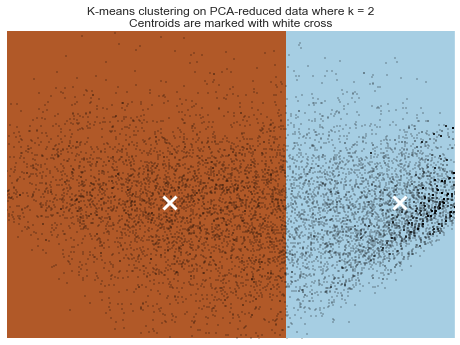

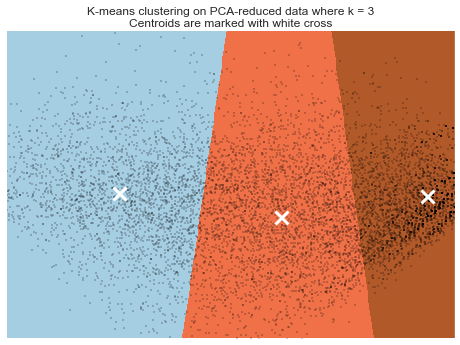

In [64]:
#@Ceslee: fix graph to plot both ax1 and ax2 not two of the first one.
# Visualize the results on PCA-reduced data
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(km_X)

ax1 = show_kmeans_plot(1, 2, kmeans, reduced_data)
ax2 = show_kmeans_plot(2, 3, kmeans, reduced_data)


The visual analysis here and the SC evaluation seems to support the existence of two clusters, but let's kick the can down the road and see what happens when we use try both. 

In [19]:
cols = {}

for k in [2,3]:
    #instantiate KMeans model
    km = KMeans(n_clusters=k, random_state=1)
    #fit model to training data
    km.fit(km_X)
    col_name = 'segment_k_' + str(k)
    #predict classes for km_X
    #new df from index + predicted class
    cols[col_name] = km.predict(km_X)

km_index = km_X.index.values.tolist()
ID_to_kmsegment = pd.DataFrame(cols, index=km_index)    

To keep track of beneficiary segment membership I've just made a little key for later analysis.  Each record included in clustering (aka was not na/dropped) corresponds to a k=2 cluster and a k=3 cluster.

In [67]:
ID_to_kmsegment.head(2)

,segment_k_2,segment_k_3
C16267634,1,2
C16194877,0,0


##Segment Profile Analysis

Now let's take a look at how the demographics between our clusters vary to get some kind of intuition about how the model has segmented our beneficiary population.  
<br>Here we'll load in our patient profiles and join in their segment membership.

In [15]:
profile = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_profile.csv'), na_values=' ', index_col='ID')

In [66]:
profile_seg = pd.concat([profile, ID_to_kmsegment], axis=1, join='inner')
profile_seg.head(1)

,AGE,RACE,GENDER,MARITALSTAT,EDUCATION,REGION,LANGUAGE,OBESE,SMOKER,DEPRESSION,MCC,AT-RISK,CC-NEED,segment_k_2,segment_k_3
C16267634,65 to 74,White,M,Married,Greater than HS/GED,Region 5 (Chicago),English,Not obese (BMI < 30),0,1,4,True,True,1,2


In [ ]:
#Build y = % of segment to evaluate relative frequency.
seg1_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 0])
seg2_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 1])
profile_seg['calc_percent'] = profile_seg['segment_k_2'].apply(lambda x: seg1_total if x == 0 else seg2_total)
sum_function = lambda x: sum(x)

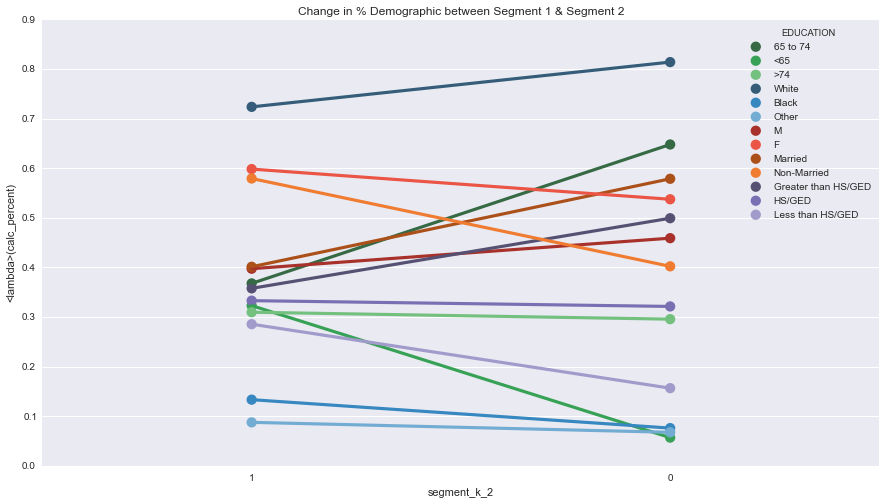

In [147]:
fig = plt.subplots(1,1, sharey=True, figsize=(15,8))

sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='AGE', data=profile_seg, palette="Greens_d").set_title('Change in % Demographic between Segment 1 & Segment 2');
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='RACE', data=profile_seg, palette="Blues_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='GENDER', data=profile_seg, palette="Reds_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='MARITALSTAT', data=profile_seg, palette="Oranges_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='EDUCATION', data=profile_seg, palette="Purples_d");

What's nice about this plot is it gives us two pieces of information: % Demographic for each segment and the % change between segment 1 and segment 2.  
<br>So for example, **Segment 1** seems to have a greater relative percentage of **<65 year olds, non-married individuals, and slighlty more women**.  **Segment 2** seems to have a greater relative percentage of **65 to 74 year olds, Whites, and individuals with greater than a HS/GED.**  Don't worry though... we're going to perform some statistical tests to see if our observed differences are actually significant.

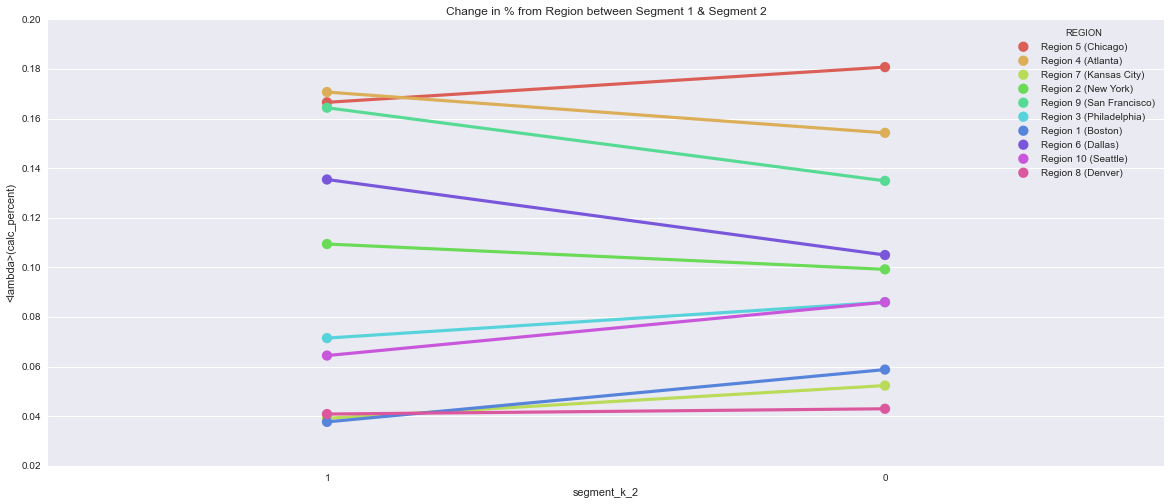

In [187]:
#@Ceslee: Can I possibly combine these charts for comparing across dimensions?
fig_region = plt.subplots(1,1, figsize=(20,8))

sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='REGION', data=profile_seg, palette="hls").set_title('Change in % from Region between Segment 1 & Segment 2');

There doesn't seem to be major regional variance.  At most there appears to be 4% difference among a region between the segments.

	 	 # of Chronic Conditions by Segment


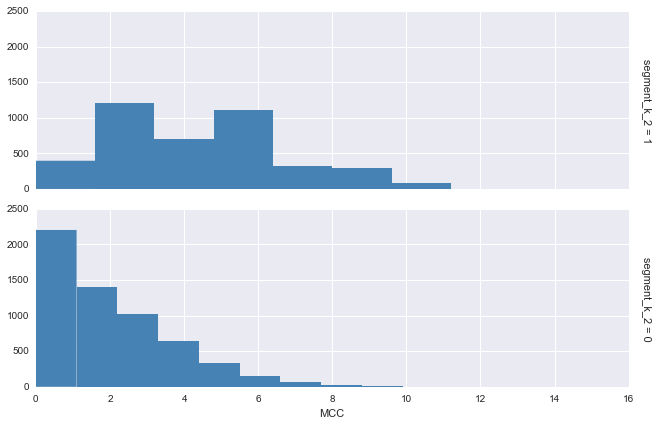

In [157]:
print '\t \t # of Chronic Conditions by Segment'
g = sns.FacetGrid(profile_seg, aspect=3, row='segment_k_2', margin_titles=True);
g.map(plt.hist, 'MCC', color="steelblue", lw=0);

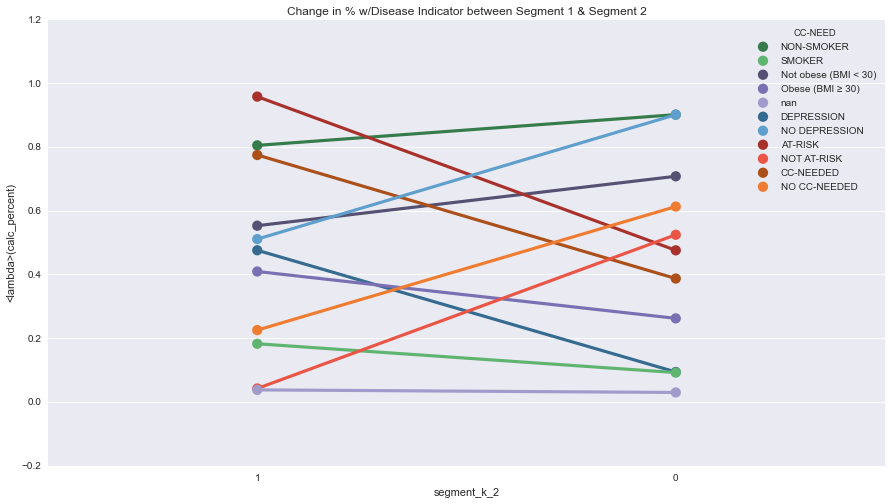

In [202]:
fig2 = plt.subplots(1,1, sharey=True, figsize=(15,8))

# profile_seg.replace({
#         'SMOKER':{0:'NON-SMOKER', 1:'SMOKER'},
#         'DEPRESSION':{0:'NO DEPRESSION',1:'DEPRESSION'},
#         'AT-RISK':{False:'NOT AT-RISK', True:'AT-RISK'},
#         'CC-NEED':{False:'NO CC-NEEDED', True:'CC-NEEDED'}
#     }, inplace=True)

# profile_seg['OBESE'] = profile_seg['OBESE'].map(lambda x: str(x).decode('utf-8').strip())

sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='SMOKER', data=profile_seg, palette="Greens_d").set_title('Change in % w/Disease Indicator between Segment 1 & Segment 2');
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='OBESE', data=profile_seg, palette="Purples_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='DEPRESSION', data=profile_seg, palette="Blues_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='AT-RISK', data=profile_seg, palette="Reds_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='CC-NEED', data=profile_seg, palette="Oranges_d");


From these preliminary results its interesting that CC-NEED, AT-RISK, DEPRESSION, and to a lesser extent SMOKING and OBESITY seem to show a similarly proportionate bias towards segment 1.  There's no doubt a latent correlation here between disease indicators and having higher gaps in your wellness profile and needs profile.  We'll explore those next.  First let's take a gander at a contingency table to see if any differences between groups are significant.

In [188]:
#@Ceslee: Contingency table from research article?


##Segment Factor Analysis

In [203]:
needs_wellness_seg = pd.concat([km_X, ID_to_kmsegment], axis=1, join='inner')
needs_wellness_seg.head(1)

,FELTNP,FELTSD,PNIACT,SCLACT,DIFBTH,DIFDRS,DIFEAT,DIFCHR,DIFWLK,DIFTOL,...,Bodily Pain,General Health,Vitality,Social Functioning,Physical Functioning,Role Physical,Role Emotional,Mental Health,segment_k_2,segment_k_3
ID,,,,,,,,,,,,,,,,,,,,,
C16267634,1,1,1,1,1,1,1,1,1,1,...,5,5,5,3,2,5,3.5,3,1,2


In [ ]:
#Build y = % of segment to evaluate relative frequency.
seg1_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 0])
seg2_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 1])
profile_seg['calc_percent'] = profile_seg['segment_k_2'].apply(lambda x: seg1_total if x == 0 else seg2_total)
sum_function = lambda x: sum(x)

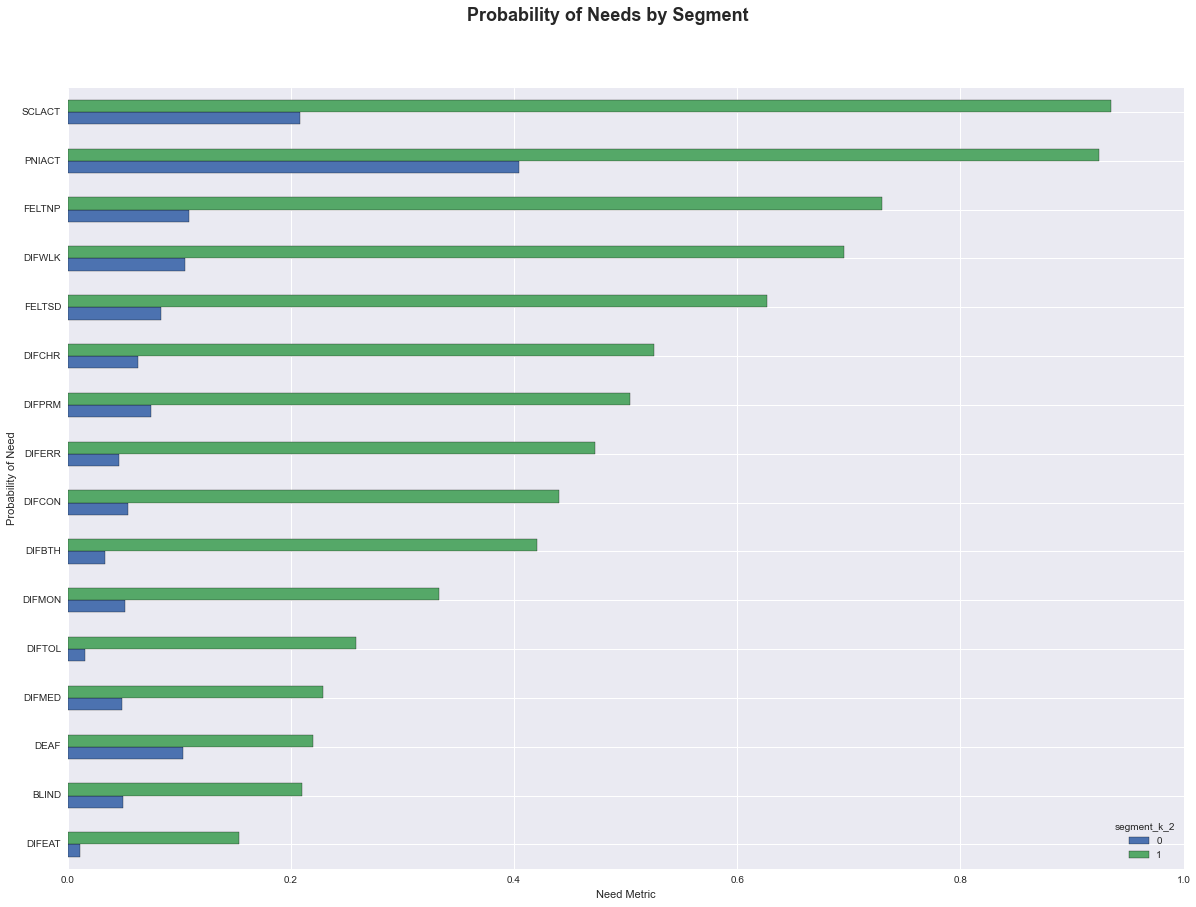

In [312]:
#@Ceslee: Maybe sub this for our handy line plots
#prob of needs in sort order vertical
fig = plt.figure()
fig.suptitle('Probability of Needs by Segment', fontsize=18, fontweight='bold')

ax = fig.add_subplot(111)
ax.set_xlabel('Need Metric')
ax.set_ylabel('Probability of Need')

needs_cols = list(needs_wellness_seg.columns[0:17])  + ['segment_k_2']
needs_seg = needs_wellness_seg[needs_col]
chart = pd.pivot_table(needs_seg, index='segment_k_2').transpose().sort(columns=[1]).plot(kind='barh', ax=ax, figsize=(20,14))

In [273]:
wellness.columns.values

array(['Bodily Pain', 'General Health', 'Vitality', 'Social Functioning',
       'Physical Functioning', 'Role Physical', 'Role Emotional',
       'Mental Health'], dtype=object)

In [286]:
#radar chart for wellness
#radar chart for dashboard -----   http://bl.ocks.org/chrisrzhou/2421ac6541b68c1680f8

#average values across segments
#accept 8 values per segment, label=health domain labels
%%html
<head>
    <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
    <title>Radar chart</title>
    <script src="http://d3js.org/d3.v3.min.js"></script>
    <script src="radar-chart/RadarChart.js"></script>
    <style>
        body {
            overflow: hidden;
            margin: 0;
            font-size: 14px;
            font-family: "Helvetica Neue", Helvetica;
        }
        #chart {
            position: floating;
            top: 50px;
            left: 100px;
        }
    </style>
</head>
<body>
    <div id="body">
        <div id="chart"></div>
    </div>
    <script src="radar-chart/script.js"></script>
</body>

In [ ]:
#Contingency Table or Features Classifier to extract insight around features
#Use logistic regression and try decision trees?

##Evaluate Model

In [ ]:
#@Ceslee: Plot AtRisk, CC-Need, segment_k_3 against health factors to evaluate
#precision for the three? how many true, true for AtR-seg, CC-seg
# pd.pivot_table(profile, index='AT-RISK')
profile_seg.pivot_table(index=['AT-RISK','CC-NEED', 'segment_k_2'])

In [ ]:
#@Ceslee:Please fix bugs/requests now

##Demo App

In [ ]:
#@Ceslee: Add Background + Design

In [ ]:
#Combine appproaches, use iPython widgets to segment by Disease/CC-Need and view segments
#@Ceslee: DEMO-compare random person with average in side-by-side window
#predict random person's CC status and At-Risk Status

In [ ]:
#@Ceslee: Write paper and you's almost there :)